In [89]:

import numpy as np
import wfdb
import os
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import lfilter, firwin, find_peaks, filtfilt, butter, spectrogram
import pywt
from pyhrv.hrv import hrv
import pyhrv
from scipy import signal as sg

## FUNCTIONS

In [2]:
def get_values(path):
  df = pd.read_csv(path, sep='\t', skiprows=3)  # saltar las dos primeras filas (encabezado)
  novena_columna = df.iloc[:, 6].values
  n = [i/1000 for i in range(0, len(novena_columna))]
  signal = [(float(valor)/(2**10)-1/2)*3.3/1009*1000 for valor in novena_columna]
  return signal

In [3]:
def get_data(path):
    signals = []
    all_meta = []  # To store metadata for each signal
    i = 0
    # Walk through all directories and subdirectories
    for root, dirs, files in os.walk(path):
        for filename in files:
            if filename.endswith('.hea'):
                base_filename = filename[:-4]
                hea_filepath = os.path.join(root, base_filename)
                try:
                    # Read the .hea file using wfdb.rdsamp
                    signal, meta = wfdb.rdsamp(hea_filepath)
                    signals.append(signal)
                    all_meta.append(meta)   
                    i+=1
                except Exception as e:
                    print(f"Failed to read {hea_filepath}: {e}")
    return signals, all_meta

In [4]:
def get_diag(all_meta, csv_file='Nombres.csv'):
    diaglist = []
    df = pd.read_csv(csv_file)
    snomed_cts = df['Snomed_CT'].tolist()
    acronym_names = df['Acronym Name'].tolist()
    full_names = df["Full Name"].tolist()
    pairedList = []
    for i in range(len(all_meta)):
      diagnostics = all_meta[i]["comments"][2].split(" ")[1].split(",")
      diaglist.append(diagnostics)
    return diaglist, full_names, snomed_cts
    


In [5]:
def flatten(lista):
    lista_flat = []
    for elemento in lista:
        if isinstance(elemento, list):
            lista_flat.append(elemento[0])
        else:
            lista_flat.append(elemento)
    return lista_flat

In [6]:
def freqCount(lista, names, code):
    frecuencias = {}
    for elemento in lista:
        if elemento in frecuencias:
            frecuencias[elemento] += 1
        else:
            frecuencias[elemento] = 1
    frecuencias
    rElements = [elemento for elemento, conteo in frecuencias.items() if conteo > 1000]
    rNames = [names[code.index(int(element))] for element in rElements if int(element) in code]
    
    return rNames, rElements

In [7]:
def filter_Wavelet(ECGsignal1):
  coeffs = pywt.wavedec(ECGsignal1, 'db4', level=4)
  threshold = 0.2
  filtered_coeffs = [pywt.threshold(coeff, threshold, mode='soft') for coeff in coeffs]
  filtered_signal = pywt.waverec(filtered_coeffs, 'db4')
  return filtered_signal

In [81]:
def normalize(signal):
    maxS = max(signal)
    minS = min(signal)
    nSignal = signal-minS/maxS - minS
    return nSignal

In [84]:
def get_signals(rCodes, meta, signals):
    pairedList = []
    dList = []
    for i in range(len(meta)):
        diagnostics = meta[i]["comments"][2].split(" ")[1].split(",")[0]
        dList.append(diagnostics)
        
    for j in range(0, len(rCodes)):
        iCode = rCodes[j]
        for k in range(0, len(dList)):
            kdList=dList[k]
            if kdList == iCode:
                pairedList.append((signals[k], int(iCode)))
    return pairedList

In [85]:
def OrderedLists(totList):
    AFlist = []
    SBlist = []
    SRlist = []
    STlist = []
    sAFlist = []
    sSBlist = []
    sSRlist = []
    sSTlist = []
    for i in totList:
        diag = i[1]
        sig = np.transpose(i[0])[1]
        filsig = filter_Wavelet(sig)
        normSig = normalize(filsig)
        if diag == 164889003:
            sAFlist.append(sig)
            AFlist.append(0)
        elif diag == 426177001:
            sSBlist.append(sig)
            SBlist.append(1)
        elif diag == 426783006:
            sSRlist.append(sig)
            SRlist.append(2)
        elif diag == 427084000:
            sSTlist.append(sig)
            STlist.append(3)
    conj = (AFlist, SBlist, SRlist, STlist) 
    conjS = (sAFlist, sSBlist, sSRlist, sSTlist)
    return conj, conjS

In [11]:
def window_signal(signal):
    sig1 = signal[:2500]
    sig2 = signal[2500:]
    return [sig1, sig2]

In [12]:
def compute_HVR(signal, fs=500):
    peaks, properties = find_peaks(signal, height=0.05, distance=int(0.5 * fs))
    rr_intervals = np.diff(peaks) / fs  
    rr_intervals = rr_intervals[rr_intervals > 0.3]
    mean_rr = np.mean(rr_intervals)
    std_rr = np.std(rr_intervals)
    rmssd = np.sqrt(np.mean(np.diff(rr_intervals)**2))
    nn50 = np.sum(np.abs(np.diff(rr_intervals)) > 0.05)
    pnn50 = (nn50 / len(rr_intervals)) * 100
    return mean_rr, std_rr, rmssd, nn50, pnn50

In [13]:
path =  "C:/Users/Eva/Downloads/a-large-scale-12-lead-electrocardiogram-database-for-arrhythmia-study-1.0.0/a-large-scale-12-lead-electrocardiogram-database-for-arrhythmia-study-1.0.0"
signals, meta = get_data(path)

Failed to read C:/Users/Eva/Downloads/a-large-scale-12-lead-electrocardiogram-database-for-arrhythmia-study-1.0.0/a-large-scale-12-lead-electrocardiogram-database-for-arrhythmia-study-1.0.0\WFDBRecords\01\019\JS01052: time data '/' does not match format '%d/%m/%Y'
Failed to read C:/Users/Eva/Downloads/a-large-scale-12-lead-electrocardiogram-database-for-arrhythmia-study-1.0.0/a-large-scale-12-lead-electrocardiogram-database-for-arrhythmia-study-1.0.0\WFDBRecords\23\236\JS23074: list index out of range


In [14]:
diag, names, code = get_diag(meta)

In [15]:
flatDiag = flatten(diag)

In [16]:
rNames, rCodes = freqCount(flatDiag, names, code)

In [86]:
totList = get_signals(rCodes, meta, signals)

In [87]:
conj, conjS = OrderedLists(totList)

## READING PARTICIPANTS' SIGNALS

In [90]:
shelloSig = get_values("shello2 (1).txt")[0:10000]
marialeSig = get_values("mariale (1).txt")[0:10000]
juanSig = get_values("juan (1).txt")[0:10000]
anaSig = get_values("AnaLucia2 (1).txt")[0:10000]

dshello = normalize(filter_Wavelet(sg.decimate(shelloSig, 2)))
dmar = normalize(filter_Wavelet(sg.decimate(marialeSig, 2)))
djuan = normalize(filter_Wavelet(sg.decimate(juanSig, 2)))
dAna = normalize(filter_Wavelet(sg.decimate(anaSig, 2)))



### Plotting the processed signals

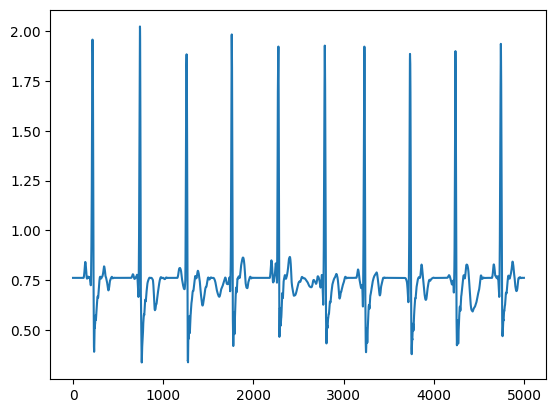

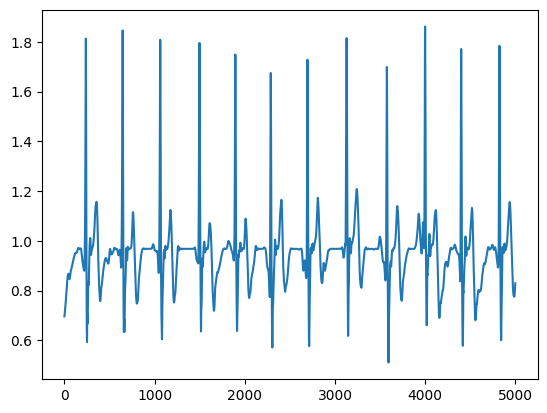

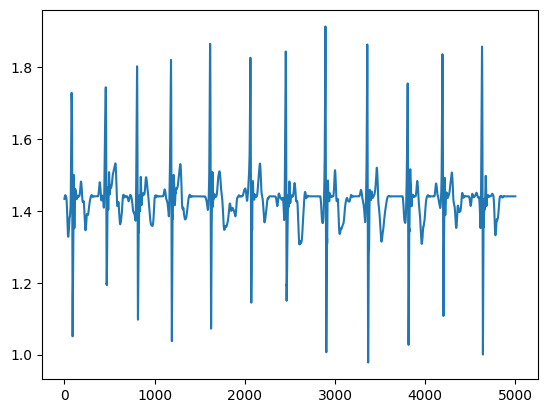

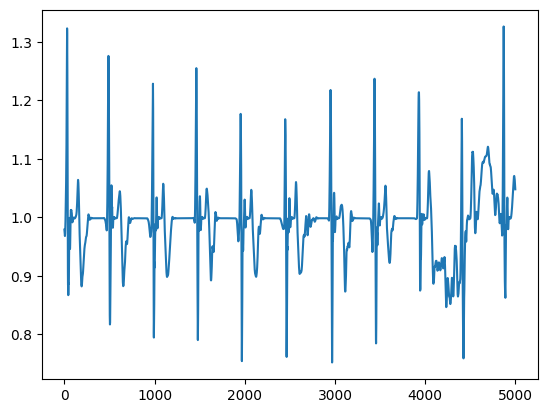

In [91]:
plt.figure()
plt.plot(dAna)
plt.figure()
plt.plot(djuan)
plt.figure()
plt.plot(dmar)
plt.figure()
plt.plot(dshello)

### Adding to the total data set

In [92]:
conjS[0].extend([dAna, djuan, dmar, dshello])

In [93]:
len(conjS[0])

1783

## Windowing Signals

In [95]:
AFsig = []
BSsig = []
NRsig = []
TSsig = []
for i in range(0, len(conjS)):
    lista = conjS[i][-1000:]
    for signal in lista:
        pair = window_signal(signal)
        if i==0:
            AFsig.extend(pair)
        elif i==1:
            BSsig.extend(pair)
        elif i==2:
            NRsig.extend(pair)
        else:
            TSsig.extend(pair)
conjSW = (AFsig, BSsig, NRsig, TSsig)
        

### Windowing Verification: Plotting the last 8 segments 

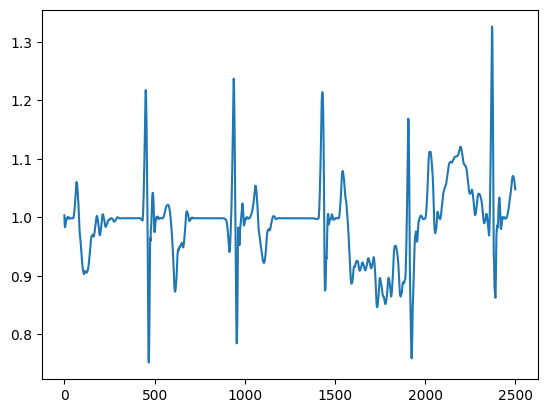

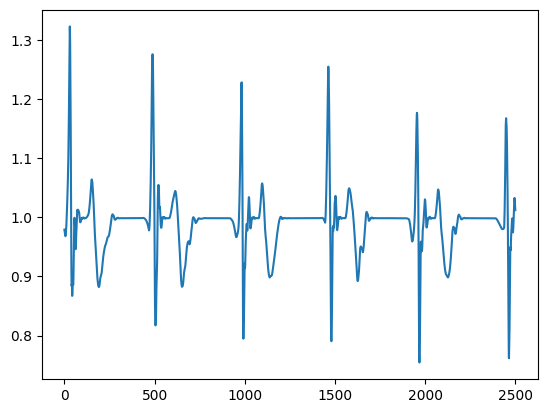

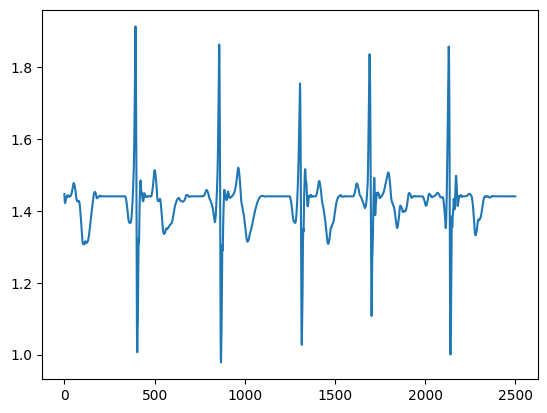

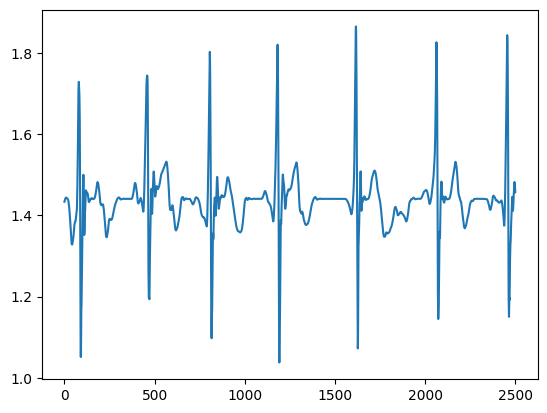

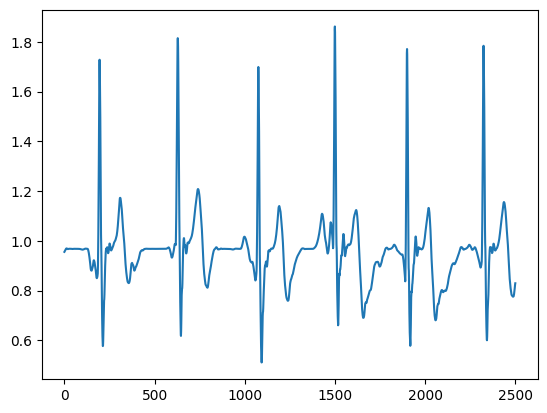

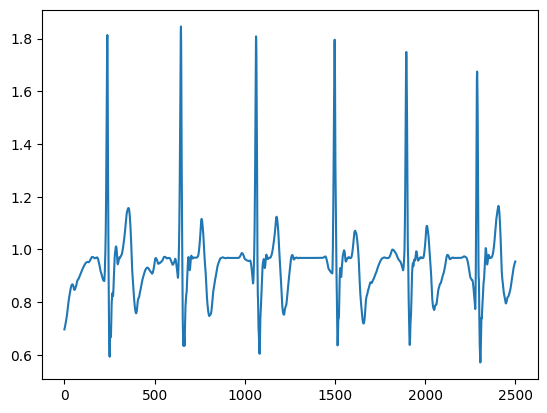

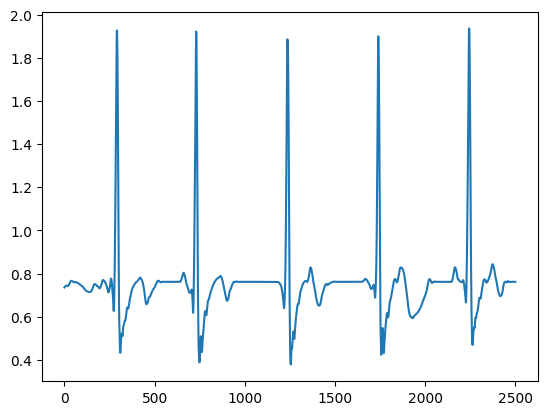

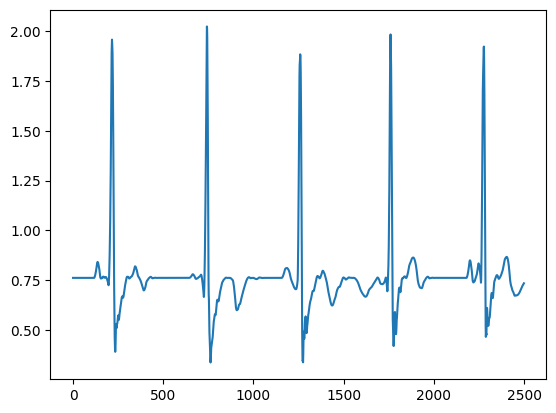

In [96]:
for i in range(1, 9):
    plt.figure()
    plt.plot(conjSW[0][-i])

## DATA EXPORTATION TO .CSV AND .XLSX


In [97]:
data = []
for i in range(0, len(conjSW)):
    lista = conjSW[i]
    for signal in lista:
        mean_rr, std_rr, rmssd, nn50, pnn50 = compute_HVR(signal)
        data.append([mean_rr, std_rr, rmssd, nn50, pnn50, i])

In [98]:
columnas = ['mean_rr', 'std_rr', 'rmssd', 'nn50', 'pnn50', 'ritmo']
df = pd.DataFrame(data, columns=columnas)
df.to_excel('datos_ritmo_cardiacoV2.xlsx', index=False)

In [99]:
columnas = ['mean_rr', 'std_rr', 'rmssd', 'nn50', 'pnn50', 'ritmo']
df = pd.DataFrame(data, columns=columnas)
df.to_csv('datos_ritmo_cardiacoV2.csv', sep=";", index=False)